In [2]:
%matplotlib inline

In [3]:
import pandas as pd

In [4]:
import seaborn as sns

In [5]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
import time;  from datetime import datetime

In [12]:
plt.rcParams["figure.figsize"] = (15,10)

In [207]:
nyc = pd.read_csv('gapi_city_data-export-2017-11-30.csv')
nyc.dropna(axis=1, how='all', inplace=True) # drops all columns where all values are NaN
nyc.drop("Organic Searches", axis=1,inplace=True) # Drops Column
nyc = nyc.loc[nyc['City'] == 1023191] # Selects records only NYC

In [208]:
weather = pd.read_csv('open_weather_6cities.csv')
weather.dropna(axis=1, how='all', inplace=True) # drops all columns where all values are NaN
weather = weather.loc[weather['city_id'] == 5128581] # Selects records only NYC

In [209]:
def unixtimestamp(row):
    return int(int(time.mktime(datetime.strptime(row, "%Y%m%d%H").timetuple())))

In [212]:
nyc['unix_time'] = nyc.apply(lambda row: unixtimestamp(str(row['Date Hour'])), axis=1)

In [211]:
#creates 13k rows with NaNs in weather columns which is because they arent in weather
df = nyc.join(weather.set_index('dt'), on='unix_time') 
# drops all rows where 'temp' is NaN
df = df.dropna(subset=['temp'])

In [219]:
df.head()

,City,Date Hour,User Type,Device Category,Sessions,Bounces,Users,Transactions,Transaction Revenue,Revenue Per User,...,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
5882,1023191,2017070200,New Visitor,mobile,3,0,3,0,0.0,0.0,...,241.0,NaN,NaN,NaN,NaN,90.0,701.0,Mist,mist,50n
5883,1023191,2017070200,New Visitor,tablet,1,1,1,0,0.0,0.0,...,241.0,NaN,NaN,NaN,NaN,90.0,701.0,Mist,mist,50n
5884,1023191,2017070200,Returning Visitor,mobile,1,0,1,0,0.0,0.0,...,241.0,NaN,NaN,NaN,NaN,90.0,701.0,Mist,mist,50n
5885,1023191,2017070201,New Visitor,mobile,5,3,6,0,0.0,0.0,...,270.0,NaN,NaN,NaN,NaN,90.0,701.0,Mist,mist,50n
5886,1023191,2017070201,Returning Visitor,desktop,1,0,1,0,0.0,0.0,...,270.0,NaN,NaN,NaN,NaN,90.0,701.0,Mist,mist,50n


In [222]:
df2 = df[["User Type",'Sessions','Transactions', 'Revenue Per User','temp','weather_id']]

In [228]:
def return_first_digit(row):
    return (str(row)[0])
df2['weather_id'] = df2['weather_id'].apply(return_first_digit)

/home/dj/programming/data_env/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [240]:
df3 = df2.drop(['Sessions','Transactions'],axis=1)

In [244]:
df4 = df3.pivot_table(index='User Type', columns='weather_id',values='Revenue Per User', aggfunc=np.average)

In [245]:
df4

weather_id,2,3,5,6,7,8
User Type,,,,,,
New Visitor,0.943720,1.161716,0.864628,1.004668,0.781226,0.886482
Returning Visitor,2.855052,2.565827,1.767166,2.099467,1.809448,1.910581


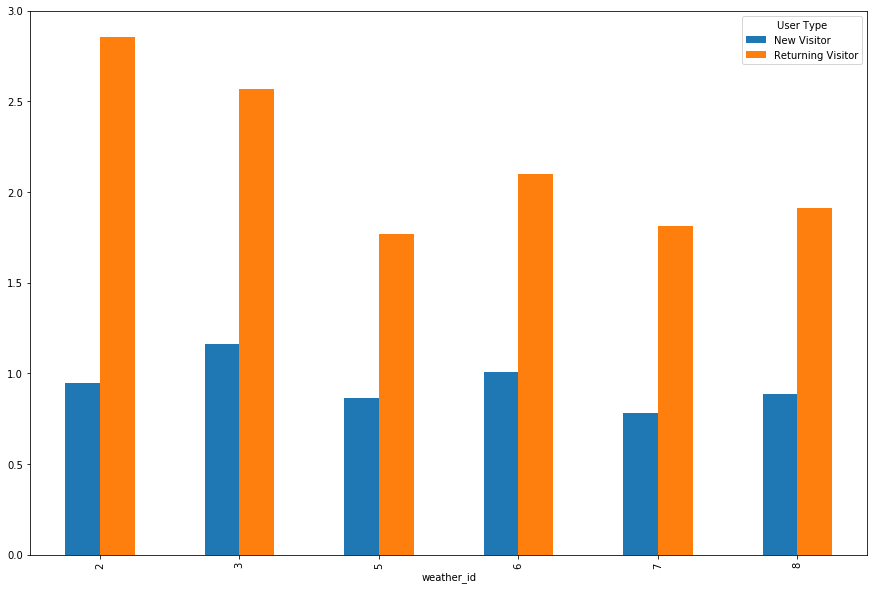

In [247]:
# Average Revenue per customer 
d = df4.transpose().plot.bar()

## Weather ID / Revenue per User Graph

#### This graph is for New York City, with Revenue Per User graphed against weather category from Open Weather Maps.  

Catergory 2, which is the umbrella category for thunderstorms, has the highest Ave. Revenue for returning customers.

What is curious is that Drizzle (Cat 3) has higher revenue than rain (Cat 4) I think it would be worth exploring how many of the rain category was light rain, before I stripped the trailing two digits that provides more detail about the kind of rain. It might make sense to move light rain to the drizzle bucket, and put more serious rain events (freezing, heavy, extreme rain) into the thunderstoms bucket, and see if there is further divergence.

There were also sometimes more than one weather classification in the weather table. Should examine those and see if they are expressed in a particular order (I took only the first one) and if we harvest value from both those values.

Once we remedy that and have some data that we think is accurate, we can do a 2 std. dev. above and below average and see if it might make s
